In [22]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

import matplotlib.pyplot as plt
# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16


In [3]:
CLASES = "street", "sea", "mountain", "glacier", "forest", "buildings"
TRAIN_DIR = Path('C:/Users/andru/Downloads/ucse-ia-2024-tp-2-clasificacion-de-imagenes/train')
TEST_DIR = Path('C:/Users/andru/Downloads/ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')
SIZE = 32

In [4]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    #horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CLASES,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [5]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)

Found 14034 images belonging to 6 classes.


In [6]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CLASES[np.argmax(labels[i])])
        plt.axis("off")

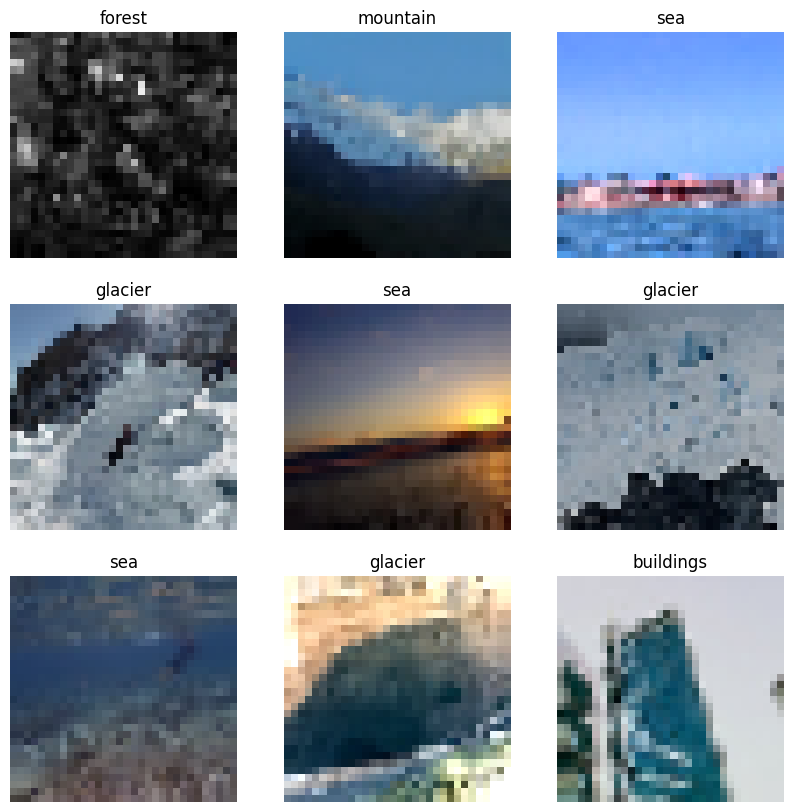

In [7]:
sample_images(train)

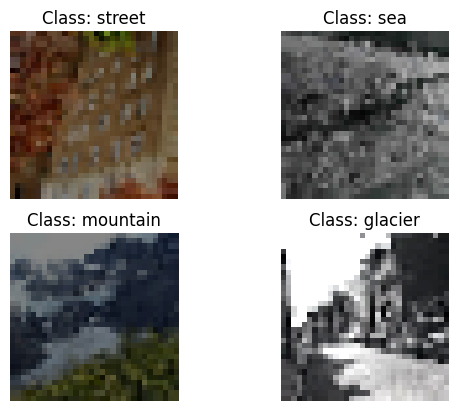

Media: [0.3935336  0.4278004  0.43909436]
Desviación estandar: [0.25316286 0.2551862  0.2938859 ]


In [60]:
for x_batch, y_batch in train:
    # Visualize a few images from the batch
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {CLASES[i]}")
        plt.axis('off')
    plt.show()

    # Calculate image statistics (e.g., mean, standard deviation)
    mean = np.mean(x_batch, axis=(0, 1, 2))
    std = np.std(x_batch, axis=(0, 1, 2))
    print("Media:", mean)
    print("Desviación estandar:", std)

    break  # Break after the first batch for demonstration

In [51]:
contador_imagenes = {}
for subcarpeta, _, _ in os.walk(TRAIN_DIR):
    imagenes = tf.io.gfile.glob(os.path.join(subcarpeta, "*.jpg"))
    contador_imagenes[subcarpeta] = len(imagenes)

for clase, cantidad in contador_imagenes.items():
    partes = clase.split('\\')
    
    clases = partes[-1].split(".")[0]  
    
    print(f"La clase {clases} tiene {cantidad} imágenes.")

La clase train tiene 0 imágenes.
La clase buildings tiene 2191 imágenes.
La clase forest tiene 2271 imágenes.
La clase glacier tiene 2404 imágenes.
La clase mountain tiene 2512 imágenes.
La clase sea tiene 2274 imágenes.
La clase street tiene 2382 imágenes.
